<a href="https://colab.research.google.com/github/ivanovjaroslaw/hometasks/blob/main/ML_PT_Course/ML_PTCourse_MicroHT1_alternative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Микро-ДЗ 1: Знакомство с машинным обучением
## Альтернативный трек: Прогноз стоимости алмазов с воспроизведённым с нуля пайплайном

## Базовое решение

### Подготовка

**Подготавливаем** окружение и загружаем данные

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

RANDOM_STATE = 42
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_eda_and_dev_tools/main/datasets/diamonds_good.csv")

Взглянем на данные

In [2]:
df.head(n = 10)

,carat,cut,color,clarity,depth,table,price,'x','y','z'
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
5,NaN,Very Good,J,VVS2,62.8,57.0,336.0,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336.0,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337.0,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337.0,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338.0,4.00,4.05,2.39


In [3]:
df.shape

(53940, 10)

Попробуем **проинтерпретировать данные** (через быстрый гуглёж):
* `carat` - караты в каких-то единицах, возможно важный "признак"
* `cut` - качество огранки
* `color` - похоже на общую прозрачность/цветастость --- шкалу "GIA" (от D до Z), где чем дальше, тем более мутное
* `clarity` - тоже про "прозрачность", но не общую, а про "включения" -- сложная величина; в порядке убывания ценности (FL/IF, VVS1/VVS2, VS1/VS2, SI1/SI2, I1, I2, I3)
* `depth` - высота алмаза? с виду процентная, видимо, как отношение общей глубины (высоты?) к минимальному диаметру
* `table` - процент какой-то там площадки верхней грани, видимо, к общему "диаметру" алмаза в ширину
* `price` - ага, наша целевая переменная, предположим что в $, потому что маленькие караты
* `x`, `y`, `z` - скорее всего трёхмерный размер короба, в который вписывается алмаз, возможно в каких-нибудь американских дюймах


Далее **оценим качество** данных перед тренировкой (с виду нужная глубока подготовка, но я не знаю как и нужного много времени и знания API):
* Явно есть `NaN` в `carat` да и возможно в других колонках. Не ясно как это правильно перевести в числа (точно не ноль) или как-то иначе учесть. Предположим, что `NaN` сработает и другого вида пропусков нет.
* Колонки `cut`, `color`, `clarity` - категориальные признаки и нужно кодирование. Однако `one-hot` здесь явно не подходит, потому что есть заданное направление ценности между категориями
* Нужно проверить и обработать потенциальные выбросы
* Явно не зря в первой домашке смотрели на корреляцию между признаками, но дальше просмотра это не двинулось. Зачем смотрели корреляцию - что это может дать и что мы можем дополнительно подшаманить из-за этого?




**Посмотрим** на общую **информацию по типам** данных в признаках

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53442 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    52950 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  float64
 7   'x'      53940 non-null  float64
 8   'y'      53935 non-null  float64
 9   'z'      53940 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.1+ MB


**Удалим строки с NaN** :
* возможно стоило бы их заменить каким-нибудь средними, но, кажется, для таких смелых предположений нужен детальный разбор и анализ
* опять же - потеря примерно тысячи данных из 54 тысяч - вроде терпимый компромисс

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52454 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    52454 non-null  float64
 1   cut      52454 non-null  object 
 2   color    52454 non-null  object 
 3   clarity  52454 non-null  object 
 4   depth    52454 non-null  float64
 5   table    52454 non-null  float64
 6   price    52454 non-null  float64
 7   'x'      52454 non-null  float64
 8   'y'      52454 non-null  float64
 9   'z'      52454 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.4+ MB


Продолжим **подготовку** данных:
* пока просто выбросим категориальные признаки, потому что не умею их кодировать

In [6]:
X_dropped_cats = df.drop(["price", "cut", "color", "clarity"], axis=1);
y = df["price"]

### Обучение

Сделаем **разбиение** на обучающую и тестовую выборки

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dropped_cats, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape

((39340, 6), (13114, 6))

Далее **обучаем линейную модель**

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# (?) а вот и сработал "NaN" - ошибка - надо его как-то обработать
model.fit(X_train, y_train)

LinearRegression()

### Оценка

**Оценим качество** прогноза

In [9]:
pred = model.predict(X_test)

pred[:10]

array([18631.71286605,  1188.97790265,  3300.45026236,   488.10629757,
       15639.20697617,  8230.64497455,  4890.11599348,   561.474826  ,
        3199.15231859,  2912.33144295])

In [10]:
y_test[:10].values

array([16353.,   986.,  3502.,   911., 15706., 11956.,  4426.,   644.,
        2724.,  1758.])

In [11]:
df.describe()

,carat,depth,table,price,'x','y','z'
count,52454.000000,52454.000000,52454.000000,52454.000000,52454.000000,52454.000000,52454.000000
mean,0.797430,61.748568,57.457734,3928.870668,5.730132,5.732533,3.537975
std,0.473549,1.431433,2.235678,3985.920112,1.121172,1.118495,0.705462
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5318.750000,6.540000,6.530000,4.030000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,31.800000,31.800000


In [12]:
mean_squared_error(y_test, pred) ** 0.5 # RMSE

1521.92680855225

Учитывая, что цена колеблется от `326 $` до `18 823 $`, а 75-персентиль `5 000 $`, кажется, что **итого отклонение в `1 521 $` достаточно плохое**.

## Возвращаем категориальные признаки

### Подготовка

Попробуем вернуть и закодировать категориальные признаки `cut`, `color`, `clarity` и посмотреть разницу

Подготовим и закодируем `cut`

In [13]:
df["cut"].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair', 'Goood'],
      dtype=object)

Поправим явный выброс в значениях

In [14]:
df['cut'] = df['cut'].replace('Goood', 'Good')
df["cut"].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

Кодируем `cut`, задаём направление гуглежом

In [15]:
ordinalencoder = OrdinalEncoder(categories = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']])
df.loc[:, 'cut'] = ordinalencoder.fit_transform(df.loc[:, 'cut'].to_frame())
df

,carat,cut,color,clarity,depth,table,price,'x','y','z'
0,0.23,4.0,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,3.0,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,1.0,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,3.0,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,1.0,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4.0,D,SI1,60.8,57.0,2757.0,5.75,5.76,3.50
53936,0.72,1.0,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,2.0,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,3.0,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


In [16]:
df["cut"].unique()

array([4.0, 3.0, 1.0, 2.0, 0.0], dtype=object)

**Дико смущает, что появился 0** (здесь и далее) (который очень особым образом ведёт себя при перемножении с весом). Также смущает заданная разница в 4 раза "больше" - я бы попробовал закодировать как-нибудь типо "1000, 1001, 1002, 1003, 1004" (чтобы уменьшить влияние данных и перенести фокус на веса), но не умею.

Подготовим и закодируем `color`

In [17]:
df["color"].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

Кодируем `color`, задаём направление гуглежом

In [18]:
ordinalencoder = OrdinalEncoder(categories = [['J', 'I', 'H', 'G', 'F', 'E', 'D']])
df.loc[:, 'color'] = ordinalencoder.fit_transform(df.loc[:, 'color'].to_frame())
df

,carat,cut,color,clarity,depth,table,price,'x','y','z'
0,0.23,4.0,5.0,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,3.0,5.0,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,1.0,5.0,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,3.0,1.0,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,1.0,0.0,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4.0,6.0,SI1,60.8,57.0,2757.0,5.75,5.76,3.50
53936,0.72,1.0,6.0,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,2.0,6.0,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,3.0,2.0,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


In [19]:
df["color"].unique()

array([5.0, 1.0, 0.0, 2.0, 4.0, 3.0, 6.0], dtype=object)

Подготовим и закодируем `clarity`

In [20]:
df["clarity"].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS1', 'I1', 'VVS2', 'IF'],
      dtype=object)

Кодируем `clarity`, задаём направление гуглежом

In [21]:
# FL/IF, VVS1/VVS2, VS1/VS2, SI1/SI2, I1, I2, I3
ordinalencoder = OrdinalEncoder(categories = [['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])
df.loc[:, 'clarity'] = ordinalencoder.fit_transform(df.loc[:, 'clarity'].to_frame())
df

,carat,cut,color,clarity,depth,table,price,'x','y','z'
0,0.23,4.0,5.0,1.0,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,3.0,5.0,2.0,59.8,61.0,326.0,3.89,3.84,2.31
2,0.23,1.0,5.0,4.0,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,3.0,1.0,3.0,62.4,58.0,334.0,4.20,4.23,2.63
4,0.31,1.0,0.0,1.0,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,4.0,6.0,2.0,60.8,57.0,2757.0,5.75,5.76,3.50
53936,0.72,1.0,6.0,2.0,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,2.0,6.0,2.0,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,3.0,2.0,1.0,61.0,58.0,2757.0,6.15,6.12,3.74


In [22]:
df["clarity"].unique()

array([1.0, 2.0, 4.0, 3.0, 6.0, 0.0, 5.0, 7.0], dtype=object)

### Обучение

Сделаем **разбиение** на обучающую и тестовую выборки

In [23]:
X_cats = df.drop(["price"], axis=1);

X_train_cats, X_test_cats, y_train_cats, y_test_cats = train_test_split(X_cats, y, test_size=0.25, random_state=42)

X_train_cats.shape, X_test_cats.shape

((39340, 9), (13114, 9))

Далее **обучаем линейную модель**

In [24]:
model_cats = LinearRegression()

model_cats.fit(X_train_cats, y_train_cats)

LinearRegression()

### Оценка

**Оценим качество** прогноза

In [25]:
pred = model_cats.predict(X_test_cats)

pred[:10]

array([18353.17631166,  1780.78538401,  3515.31658845,   723.91018521,
       14903.7523378 ,  9698.80076375,  4438.56287035,   657.7951401 ,
        2897.56706555,  1775.74532697])

In [26]:
y_test_cats[:10].values

array([16353.,   986.,  3502.,   911., 15706., 11956.,  4426.,   644.,
        2724.,  1758.])

In [ ]:
df.describe()

,carat,depth,table,price,'x','y','z'
count,52454.000000,52454.000000,52454.000000,52454.000000,52454.000000,52454.000000,52454.000000
mean,0.797430,61.748568,57.457734,3928.870668,5.730132,5.732533,3.537975
std,0.473549,1.431433,2.235678,3985.920112,1.121172,1.118495,0.705462
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.520000
75%,1.040000,62.500000,59.000000,5318.750000,6.540000,6.530000,4.030000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,31.800000,31.800000


In [27]:
mean_squared_error(y_test_cats, pred) ** 0.5 # RMSE

1228.3957108465868

## Итог

Учитывая, что цена колеблется от `326 $` до `18 823 $`, а 75-персентиль `5 000 $`, кажется, что:
* с кодировкой категориальных признаков **итого отклонение в `1 228 $` всё ещё достаточно плохое**
* по сравнению с прошлым результатом (с выброшенными категориями) в `1 521 $`

**Постскриптум**:
* В конце начал смотреть `plt.scatter(df["'x'"], df['price'])` и увидел несколько нулевых значений в `'x'`. По интерпретации этого столбца как физического размера - явно ошибка данных. Такие выбросы точно стоит учесть (выбросить?), но, с виду, их очень мало и они не сильно повлияют на результат
* Пока только идея использовать нелинейную регрессию

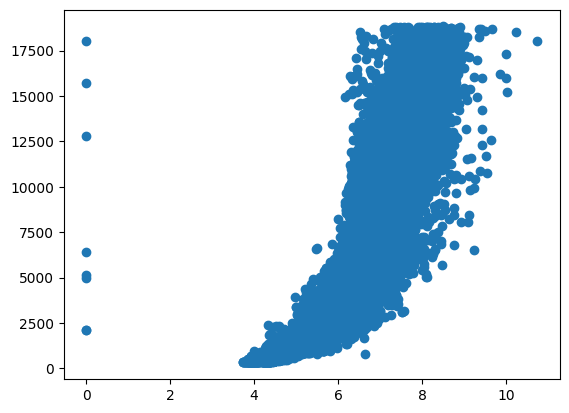

In [35]:
from matplotlib import pyplot as plt

plt.scatter(df["'x'"], df['price'])

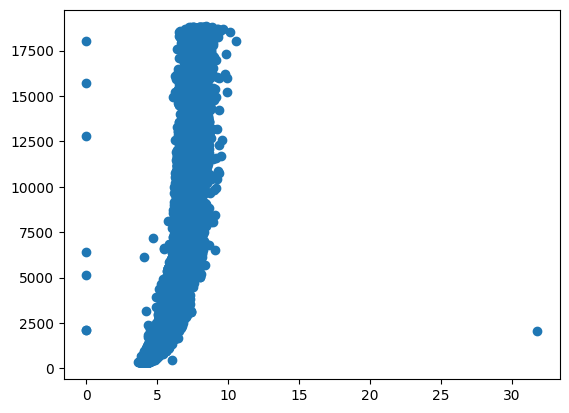

In [36]:
plt.scatter(df["'y'"], df['price'])

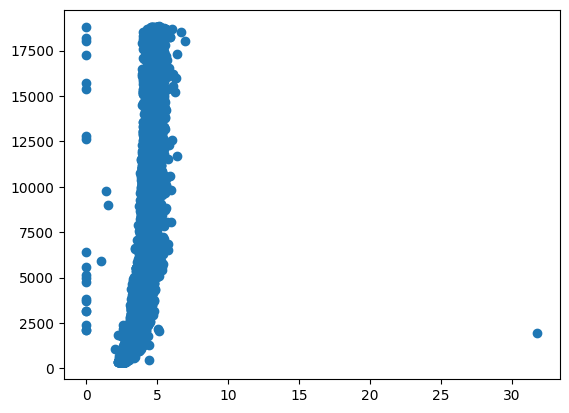

In [37]:
plt.scatter(df["'z'"], df['price'])